In [38]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

In [41]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X.columns)

Index(['saledays', 'living_space', 'ground_space', 'rooms', 'owner_expenses',
       'Apartment', 'Holiday home', 'Terraced house', 'Villa', 'land',
       'Energimærke A', 'Energimærke B', 'Energimærke C', 'Energimærke D',
       'Energimærke E', 'Energimærke F', 'Energimærke G', 'age', 'Bornholm',
       'Byen København', 'Fyn', 'Københavns omegn', 'Nordjylland',
       'Nordsjælland', 'Sydjylland', 'Vest- og Sydsjælland', 'Vestjylland',
       'Østjylland', 'Østsjælland'],
      dtype='object')


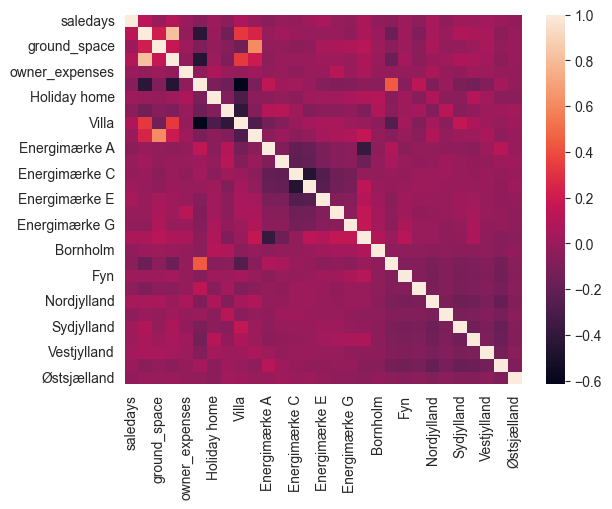

In [4]:
## Heat map
XcorrHeat = sns.heatmap(X.corr())
fig = XcorrHeat.get_figure()
plt.savefig('Xvar_corr_heat_map.png', bbox_inches='tight')

In [42]:
## Main model
eta = 0.01
gradient_booster = HistGradientBoostingClassifier(learning_rate=eta)
# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict_0de = gradient_booster.predict(X_test)

In [43]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict_0de)
r2_GBM

0.24503146813842847

In [44]:
RMSE_GBM = mse(y_test,y_test_predict_0de,squared=False)
RMSE_GBM

2710335.5680292062

In [8]:
## Define hyperpara
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}


In [9]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = {
            'max_depth': max_depth,
            'learning_rate': learning_rate
        }
        
        model = HistGradientBoostingClassifier(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print('Best Parameters:', best_params)
print('Best Score:', -best_score)  # Convert back to positive mean squared error

# Fitting the model with best para
final_model = HistGradientBoostingClassifier(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

Best Parameters: {'max_depth': 1, 'learning_rate': 0.01}
Best Score: 5035554560458.027


In [11]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.3190489269449498